In [28]:
!pip install squarify

In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_csv('online_retail.csv', encoding="ISO-8859-1")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [31]:
df.dropna(subset=['CustomerID'], inplace=True)

In [32]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [33]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [34]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [35]:
print(f"البيانات نظيفة الآن! عدد السجلات المتبقية: {len(df)}")

البيانات نظيفة الآن! عدد السجلات المتبقية: 397884


In [36]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [37]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [38]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                 # Frequency (عدد الفواتير الفريدة)
    'TotalSum': 'sum'                                       # Monetary
})

In [39]:
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [40]:
rfm["R_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

In [41]:
rfm["F_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

In [42]:
rfm["M_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [43]:
rfm["RFM_Segment"] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str)

In [44]:
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,2,7,4310.00,5,5,5,55
12348.0,75,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,310,1,334.40,1,1,2,11


In [45]:
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': "Can't Loose Them",
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [46]:
rfm['Segment'] = rfm['RFM_Segment'].replace(seg_map, regex=True)

In [47]:
print(rfm['Segment'].value_counts())

Segment
Hibernating            1065
Loyal Customers         827
Champions               633
At Risk                 580
Potential Loyalists     492
About to Sleep          351
Need Attention          186
Promising                99
Can't Loose Them         63
New Customers            42
Name: count, dtype: int64


In [48]:
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Segment,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,Hibernating
12347.0,2,7,4310.00,5,5,5,55,Champions
12348.0,75,4,1797.24,2,4,4,24,At Risk
12349.0,19,1,1757.55,4,1,4,41,Promising
12350.0,310,1,334.40,1,1,2,11,Hibernating


In [50]:
seg_counts = rfm['Segment'].value_counts()

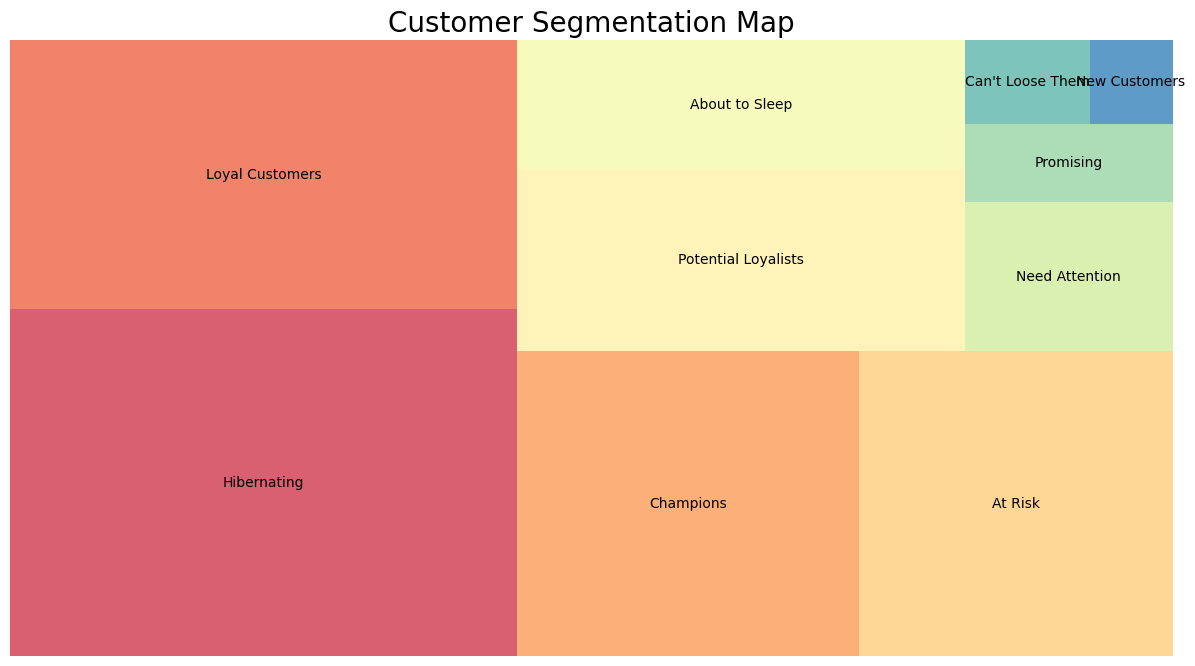

In [51]:
plt.figure(figsize=(15, 8))
squarify.plot(sizes=seg_counts.values, label=seg_counts.index, 
              alpha=0.8, color=sns.color_palette("Spectral", len(seg_counts)))
plt.title("Customer Segmentation Map", fontsize=20)
plt.axis('off')
plt.show()

In [54]:
rfm_stats = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

In [55]:
print("Segment Statistics:")

Segment Statistics:


In [56]:
print(rfm_stats)

                    Recency Frequency Monetary      
                       mean      mean     mean count
Segment                                             
About to Sleep         53.5       1.2    461.1   351
At Risk               155.1       2.9   1076.5   580
Can't Loose Them      132.4       8.4   2796.2    63
Champions               5.9      12.4   6857.9   633
Hibernating           217.9       1.1    487.7  1065
Loyal Customers        33.5       6.5   2856.7   827
Need Attention         53.1       2.3    889.2   186
New Customers           6.9       1.0    388.2    42
Potential Loyalists    17.1       2.0   1034.9   492
Promising              23.4       1.0    355.4    99


Key Insights & Action Plan:

    Retention Priority: Our Loyal Customers (827 customers) and Champions (633 customers) are the backbone of the revenue. We must launch a Loyalty Program to keep them engaged.

    Win-back Strategy: The At Risk segment (580 customers) has a high monetary average (1076.5) but they haven't visited in 155 days. A personalized "We Miss You" discount code is highly recommended here.

    Reactivation vs. Loss: With 1065 customers in the Hibernating stage, we should evaluate if it's worth the marketing spend to bring them back or focus on New Customers (42 customers) who are just starting their journey